# Machine Learning project: predicting apartment rents in Turkey using data from emlakjet.com

## Step 1: Web scraping apartment data from emlakjet.com

In order to predict apartment rents in Turkey, we need to obtain apartments data. The two major real estate portals in Turkey are sahibinden.com and emlakjet.com. Sahibinden.com restricts access to the website to non-Turkish IPs, while emlakjet.com has a static HTML website very suitable for webscraping. Therefore, I will scrap apartment data from emlakjet.com.

In order to do so, I will first import the necessary modules for webscraping and data preprocessing:

In [ ]:
# Importing necessary libraries and modules
from lxml import html
import requests
from bs4 import BeautifulSoup
from unidecode import unidecode
import pandas as pd
import time
import tqdm
import concurrent.futures
import re
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

After importing the necessary libraries and modules, I will define a function to configure session with connection pooling and retry strategy. This will allow us to webscrap all the apartments faster while not overloading too much the server (to prevent an IP ban). 

In [ ]:
def create_session():
    session = requests.Session()
    retry_strategy = Retry(
        total=3,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        backoff_factor=1
    )
    adapter = HTTPAdapter(pool_connections=10, pool_maxsize=10, max_retries=retry_strategy)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    session.headers.update({"User-Agent": "Mozilla Firefox 12.0"})
    return session

If we look at the structure of emlakjet.com, the links of rental listings are structured in the following way:
https://www.emlakjet.com/kiralik-konut/{province}-{district}/emlakcidan (where province is the name of the province and district is the name of the district in ASCII characters). Therefore, if we get the list of provinces and districts in Turkey and transform it to ASCII format, we will be able to loop through the website and get all the apartment data. 

To do so, I will define a function that extracts the name of provinces (il) and districts (ilçe) in Turkey from drdatastats.com and stores it in a dictionary:

In [ ]:
def get_provinces_districts():
    url = "https://www.drdatastats.com/turkiye-il-ve-ilceler-listesi/"
    session = create_session()
    response = session.get(url)
    
    provinces_dict = {}
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table')
        
        for row in table.find_all('tr')[1:]:
            columns = row.find_all('td')
            province = columns[1].text.strip()
            district = columns[2].text.strip()
            province_ascii = unidecode(province).lower()
            district_ascii = unidecode(district).lower()
            
            if province_ascii not in provinces_dict:
                provinces_dict[province_ascii] = []
            provinces_dict[province_ascii].append(district_ascii)
    
    #This part fixes some districts names so they are consistent with how they are spelled in emlakjet.com links
    for province, districts in provinces_dict.items():
        provinces_dict[province] = [province + "-merkez" if d == "merkez" else "19-mayis" if d == "19 mayis" else d for d in districts]
    
    return provinces_dict

With this function to get provinces and districts names, we can already start webscraping. To do so, I will define three functions:

1. extract_apartment_data -> Extracts apartment data from a single ad
2. process_page -> Process a single page of apartment listings
3. process_district -> Process all the pages of apartment listings for a district

In [ ]:
# Extracts apartment data from a single ad

def extract_apartment_data(apartment_link, session):
    try:
        apartment_response = session.get(apartment_link)
        apartment_tree = html.fromstring(apartment_response.content)
        
        # Extract price using regex to handle potential inconsistencies
        price_elements = apartment_tree.xpath("//*[@class='styles_price__6zH_9']/text()")
        price = price_elements[0].strip() if price_elements else ""
        
        # Extract location, province, district and neighborhood (mahalle) of the apartments
        location_elements = apartment_tree.xpath("//*[@class='styles_location__Y01SC']/text()")
        if location_elements and " - " in location_elements[0]:
            location = location_elements[0].split(" - ")
            province_2 = location[0] if len(location) > 0 else ""
            district_2 = location[1] if len(location) > 1 else ""
            neighborhood = location[2] if len(location) > 2 else ""
        else:
            province_2, district_2, neighborhood = "", "", ""
        
        # Extract apartment info using HTML xpath 
        info = {}
        info_items = apartment_tree.xpath("//*[@id='ilan-hakkinda']/div/div/ul/li")
        for item in info_items:
            label = item.xpath(".//span[1]//text()")
            value = item.xpath(".//span[2]//text()")
            if label and value:
                key = label[0].strip()
                info[key] = value[0].strip()
        
        # Create apartment data dictionary using website labels
        return {
            "price": price,
            "province": province_2,
            "district": district_2,
            "neighborhood": neighborhood,
            "ad_number": info.get("İlan Numarası", ""),
            "ad_publication_date": info.get("İlan Oluşturma Tarihi", ""),
            "ad_update_date": info.get("İlan Güncelleme Tarihi", ""),
            "type_1": info.get("Türü", ""),
            "type_2": info.get("Tipi", ""),
            "net_m2": info.get("Net Metrekare", ""),
            "brut_m2": info.get("Brüt Metrekare", ""),
            "number_rooms": info.get("Oda Sayısı", ""),
            "age": info.get("Binanın Yaşı", ""),
            "apartment_floor": info.get("Bulunduğu Kat", ""),
            "floors_of_building": info.get("Binanın Kat Sayısı", ""),
            "heating_type": info.get("Isıtma Tipi", ""),
            "usage_status": info.get("Kullanım Durumu", ""),
            "credit_elegibility": info.get("Krediye Uygunluk", ""),
            "investment_eligibility": info.get("Yatırıma Uygunluk", ""),
            "building_status": info.get("Yapı Durumu", ""),
            "building_type": info.get("Yapı Tipi", ""),
            "title_deed_status": info.get("Tapu Durumu", ""),
            "inside_side": info.get("Site İçerisinde", ""),
            "rental_income": info.get("Kira Getirisi", ""),
            "swap": info.get("Takas", ""),
            "number_bathrooms": info.get("Banyo Sayısı", ""),
            "balcony_status": info.get("Balkon Durumu", ""),
            "number_balconies": info.get("Balkon Sayısı", ""),
            "balcony_type": info.get("Balkon Tipi", ""),
            "balcony_m2": info.get("Balkon Metrekare", ""),
            "WC_number": info.get("WC Sayısı", ""),
            "price_status": info.get("Fiyat Durumu", "")
        }
    except Exception as e:
        print(f"Error extracting data from {apartment_link}: {e}")
        return None

# Process a single page of apartment listings
def process_page(page_url, session):
    try:
        page_response = session.get(page_url)
        page_tree = html.fromstring(page_response.content)
        
        # Parsing all the ad links of a page
        apartment_hrefs = page_tree.xpath("*//div[1]/div[4]/div[2]/div[3]//div/a/@href")
        
        # Use a list comprehension to build full URLs
        apartment_links = [f"https://www.emlakjet.com{href}" for href in apartment_hrefs]
        
        # Process apartment links with limited concurrency to avoid overwhelming the server
        apartments_data = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            futures = [executor.submit(extract_apartment_data, link, session) for link in apartment_links]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                if result:
                    apartments_data.append(result)
        
        return apartments_data
    except Exception as e:
        print(f"Error processing page {page_url}: {e}")
        return []

# Process all the pages of a district

def process_district(province, district, session):
    base_url = f"https://www.emlakjet.com/kiralik-konut/{province}-{district}/emlakcidan/"
    try:
        response = session.get(base_url)
        tree = html.fromstring(response.content)
        soup = str(BeautifulSoup(response.content, "html.parser"))

        # We add this so, in case there isn't any apartment for rent in a district, there isn't an error
        if "Aradığınız kriterlere uygun ilan bulunamadı." in soup:
            return []
        
        # We get the number of apartments for rent in a district using xpath
        num_apt_elements = tree.xpath("//*[@class='styles_strong__cM487']/text()")
        if not num_apt_elements:
            return []
            
        # Clean and parse the number
        num_text = num_apt_elements[0].replace(".", "")
        num_apartments = int(re.sub(r'\D', '', num_text)) if re.search(r'\d', num_text) else 0
        
        # Calculate the number of listing pages that a district has (each page has a max of 30 ads, and the max number of ads shown is 1500)
        n_pages = min(((num_apartments // 30) + 1), 50)

        # Create an empty list to store all the data
        all_apartments_data = []
        # Create URLs for all pages at once
        page_urls = [f"{base_url}{page}" for page in range(1, n_pages+1)]
        
        # We process pages with limited concurrency to web scrap faster without overwhelming the server
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = [executor.submit(process_page, url, session) for url in page_urls]
            for future in tqdm.tqdm(concurrent.futures.as_completed(futures), 
                                   total=len(page_urls), 
                                   desc=f"Pages in {province.capitalize()}, {district.capitalize()}", 
                                   leave=False):
                result = future.result()
                all_apartments_data.extend(result)
                
        return all_apartments_data
    except Exception as e:
        print(f"Error processing district {province}-{district}: {e}")
        return []

With these functions ready, I can write a function main() to run the script and start webscraping. As there are over 50.000 apartments for rent listed in emlakjet.com, webscraping takes approximately 2 hours. 

In [ ]:
def main():
    start_time = time.time()
    session = create_session()
    provinces_dict = get_provinces_districts()
    
    all_apartments_data = []

    # Looping over all provinces and districts, adding a bar to see progress
    for province in tqdm.tqdm(provinces_dict, desc="Provinces processed"):
        for district in provinces_dict[province]:
            time.sleep(0.5)
            district_data = process_district(province, district, session)
            all_apartments_data.extend(district_data)
    
    # Save results as a DataFrame and export it to Excel
    apartments_dataframe = pd.DataFrame(all_apartments_data)
    apartments_dataframe.to_excel("apartments_for_rent.xlsx", index=False)

    # Collect statistics of webscraping 
    end_time = time.time()
    print(f"Scraping completed in {end_time - start_time:.2f} seconds")
    print(f"Total apartments collected: {len(all_apartments_data)}")

if __name__ == "__main__":
    main()

# Step 2: Data preprocessing

Once we have extracted all the data, we can import it using pandas and start analyzing the data:

In [105]:
# Importing again necessary libraries to avoid re-running previous cells and re-start webscraping

import pandas as pd
rented_apartments = pd.read_excel("apartments_for_rent.xlsx")
print(rented_apartments.shape)
print(rented_apartments.info())

(54273, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   price                54273 non-null  object
 1   province             54273 non-null  object
 2   district             54273 non-null  object
 3   neighborhood         54273 non-null  object
 4   ad_number            54273 non-null  int64 
 5   ad_publication_date  54273 non-null  object
 6   ad_update_date       54273 non-null  object
 7   type_1               54273 non-null  object
 8   type_2               54273 non-null  object
 9   net_m2               54070 non-null  object
 10  brut_m2              54273 non-null  object
 11  number_rooms         54273 non-null  object
 12  age                  54269 non-null  object
 13  apartment_floor      51777 non-null  object
 14  floors_of_building   54273 non-null  int64 
 15  heating_type         54273 non-null  obje

## Data validation and cleaning

The dataset contains **54273 rows** and **24 columns**:

- **price**: Apartment rent (in TL). It's in string type, has to be converted to int type.
- **province**: Name of the province (*il*) where the apartment is located. It's in string type, it has to be converted to categorical type.
- **district**: Name of the district (*ilçe*) where the apartment is located. It's in string type, it has to be converted to categorical type.
- **neighborhood**: Name of the neighborhood (*mahalle*) where the apartment is located. It's in string type, it has to be converted to categorical type.
- **ad_number**: ID of the ad. It's a string type, it has to be converted to int type.
- **ad_publication_date**: Date in which the ad was published.
- **ad_update_date**: Date in which the ad was updated.
- **type_1**: Type of the apartment. As all the apartments are housing (*konut*) type, this variable can be removed.
- **type_2**: Specific type of the apartment. There are 15 types of apartments in the dataset. It's a string variable that has to be converted to categorical type.
- **net_m2**: Net m2 of the apartment. It's in string type, must be converted to int type.
- **brut_m2**: Brut m2 of the apartment. It's in string type, must be converted to int type.
- **number_rooms**: Number of rooms of the apartment in Turkish format. It has to be converted to a raw number using a formula, and converted to int type.
- **age**: Age of the building in 5 categories. As the categories are ordered in year brackets, I will use the mean values of these categories, and convert this variable to float type.
- **apartment_floor**: The floor in which the apartment is located. It includes both numbers and a set of special categories: garden floor (*bahçe katı*), garden duplex (*bahçe duplex*), basement floor (*bodrum kat*), roof duplex (*çatı dubleks*), flat entrance - ground (*düz giriş - zemin*), family house (*müstakil*), villa (*villa tipi*), and high entrance (*yüksek giriş*). I will convert these categories to numbers and the variable to a numeric type.
- **floors_of_building**: Number of floors of the building. It's in string type and has to be converted to numeric type.
- **heating_type**: Type of heating of the apartment. It's a string variable with categories, so it has to be converted to categorical variable.
- **usage_status**: Whether the apartment is currently empty (*boş*), are tenants living (*kıracı oturuyor*), or the house owners are living (*mülk sahibi oturuyor*). It's a string variable that has to be converted to category.
- **dues**: Dues in TL.
- **title_deed_status**: Title deed status of the apartment. It has to be converted to categorical type.
- **inside_site**: Specifies whether apartment is in the site or not. It has to be converted to boolean.
- **deposit**: The amount of deposit that has to be paid to the owner to rent the apartment in TL.
- **number_bathrooms**: The number of bathrooms of the apartment. It has to be converted to int type. 
- **balcony_status**: Whether the apartment has a balcony or not. It has to be converted to boolean.
- **price_status**: Whether the rent is subjected to the general price (*genel fiyat*) or to the unit price (*birim fiyat*). It has to be converted to categorical type.

Now, I will clean and pre-process the variables so they are in the correct datatype and have the correct format as specified.

In [106]:
import numpy as np

rented_apartments["price"] = rented_apartments["price"].str.replace(".", "").astype("int")

rented_apartments["neighborhood"] = rented_apartments["neighborhood"].str.replace(" Mahallesi", "")

rented_apartments["ad_number"] = rented_apartments["ad_number"].astype("int")

rented_apartments["type_2"] = rented_apartments["type_2"].astype("category")

rented_apartments["net_m2"] = rented_apartments["net_m2"].str.replace(" m²","")
rented_apartments["net_m2"] = rented_apartments["net_m2"].str.replace(".", "").astype("Int64")

rented_apartments["brut_m2"] = rented_apartments["brut_m2"].str.replace(" m²","")
rented_apartments["brut_m2"] = rented_apartments["brut_m2"].str.replace(".", "").astype("Int64")

# Here I assumed that studios have one room, and used a formula to get the total number of rooms
rented_apartments["number_rooms"] = rented_apartments["number_rooms"].str.replace("Stüdyo", "1").str.replace("+ Oda", "").str.replace(" Oda", "").str.replace("+", " ")
rented_apartments["number_rooms"] = rented_apartments["number_rooms"].apply(lambda x: sum(map(float, x.split())))

# I calculate a new variable "age numeric", who takes the mean of the age brackets
rented_apartments["age_numeric"] = rented_apartments["age"].str.replace("5-10", "7.5").str.replace("11-15", "12.5").str.replace("16-20", "18").str.replace("21 Ve Üzeri", "25").str.replace(" (Yeni)", "").astype("float")

# Here, I replaced special categories of apartment floor by numbers using the following schema:
## Flat entrance (ground) -> 0
## Private house -> 0
## Garden floor -> -1
## Garden duplex -> -2
## Basement floor -> -1
## Villas -> 1
## Roof duplex -> 2
## Roof floor -> 3
## High entrance -> 0.5
rented_apartments["apartment_floor_numeric"] = rented_apartments["apartment_floor"].str.replace(".Kat", "").str.replace("Kot 1 (-1)", "-1").str.replace("Kot 2 (-2)", "-2").str.replace("Kot 3 (-3)", "-3").str.replace("Kot 4 (-4)", "-4").str.replace("Düz Giriş (Zemin)", "0").str.replace("Müstakil", "0").str.replace("Bahçe Katı", "-1").str.replace("Bahçe Dublex", "-2").str.replace("Bodrum Kat", "-1").str.replace("Çatı Dubleks", "2").str.replace("Çatı Katı", "3").str.replace("Villa Tipi", "1").str.replace("+", "").str.replace("Yüksek Giriş", "0.5")
rented_apartments["apartment_floor_numeric"] = rented_apartments["apartment_floor_numeric"].astype("float")

rented_apartments["floors_of_building"] = rented_apartments["floors_of_building"].astype("Int64")

rented_apartments["heating_type"] = rented_apartments["heating_type"].astype("category")

rented_apartments["usage_status"] = rented_apartments["usage_status"].astype("category")

rented_apartments["dues"] = rented_apartments["dues"].str.replace(" TL", "").replace("", np.nan).astype("float").astype("Int64")

rented_apartments["title_deed_status"] = rented_apartments["title_deed_status"].astype("category")

rented_apartments["inside_side"] = np.where(rented_apartments["inside_side"] == "Evet", True, False)

rented_apartments["deposit"] = rented_apartments["deposit"].str.replace(" TL", "").replace("", np.nan).astype("float").astype("Int64")

# I converted 6+ bathrooms to 7
rented_apartments["number_bathrooms"] = rented_apartments["number_bathrooms"].replace("Yok", "0")
rented_apartments["number_bathrooms"] = rented_apartments["number_bathrooms"].replace("6+", "7").astype("float").astype("Int64")

rented_apartments["balcony_status"] = rented_apartments["balcony_status"].replace("Var", True)
rented_apartments["balcony_status"] = rented_apartments["balcony_status"].replace("Yok", False)

rented_apartments["price_status"] = rented_apartments["price_status"].astype("category")

## Handling missing values and outliers

Once having validated the data, we have to deal with missing values and outliers. To do so, we will first get which variables have missing values

In [29]:
rented_apartments.isna().sum()

price                          0
province                       0
district                       0
neighborhood                   0
ad_number                      0
ad_publication_date            0
ad_update_date                 0
type_1                         0
type_2                         0
net_m2                       203
brut_m2                        0
number_rooms                   0
age                            4
apartment_floor             2496
floors_of_building             0
heating_type                   0
usage_status                   0
dues                       46314
title_deed_status              5
inside_side                    0
deposit                    43832
number_bathrooms               4
balcony_status             46925
price_status                   0
age_numeric                    4
apartment_floor_numeric     2496
dtype: int64

We see that net_m2, apartment_floor, dues, deposit, balcony_status and apartment_floor_numeric have missing values. For missing values of net_m2, it seems reasonable to use brut_m2 as a proxy. As for apartment_floor_numeric, after inspecting the data, it turns out that those apartments with missing values are housings and villas, so I will fill them with 0. As for the number of bathrooms, I will assume that those apartments with missing values have 0 bathrooms. As dues, deposit and balcony_status have over 80% of missing values, I will delete them from the dataset. I will also delete variables that we won't use as they don't have important information (like type_1, ad_publication_date and ad_update_date) or that we already converted to numeric (like apartment_floor and age). Finally, I will remove duplicates to control for multiple ads of the same apartment.

In [107]:
# Fill missing values of net_m2 with brute_m2
rented_apartments["net_m2"] = rented_apartments["net_m2"].fillna(rented_apartments["brut_m2"])

# Assume that apartments with no specified number of bathrooms don't have bathrooms
rented_apartments["number_bathrooms"] = rented_apartments["number_bathrooms"].fillna(0)

# Apartments with no specified apartment floor are houses and villas, so we replace missing values with 0
rented_apartments["apartment_floor_numeric"] = rented_apartments["apartment_floor_numeric"].fillna(0)

# We drop "dues", "deposit" and "balcony_status" as most observations are missing values

rented_apartments = rented_apartments.drop(["dues", "deposit", "balcony_status", "apartment_floor", "age", "ad_publication_date", "ad_update_date", "type_1"], axis=1)

# We drop the rest of missing values
rented_apartments = rented_apartments.dropna()

# We remove duplicates
rented_apartments = rented_apartments.drop_duplicates()

Now, we have to deal with outliers, as these data points can have a disproportionate influence on model predictions. Specifically, I will remove those apartments whose price is lower or higher than 1.5 times the interquartilic range (IQR). Moreover, I will remove the few apartments that have over 500 net_m2 from the dataset.

In [108]:
q3 = rented_apartments["price"].quantile(0.75)
q1 = rented_apartments["price"].quantile(0.25)
iqr = q3-q1

outliers = rented_apartments[(rented_apartments["price"] < (q1 - 1.5*iqr)) | (rented_apartments["price"] > (q3 + 1.5*iqr))]

rented_apartments.drop(outliers.index, inplace=True)
rented_apartments.reset_index(drop = True, inplace=True)

rented_apartments = rented_apartments[rented_apartments["net_m2"] < 500]

# Checking shape and missing values again
print(rented_apartments.shape)
print(rented_apartments.isna().sum())

(49032, 18)
price                      0
province                   0
district                   0
neighborhood               0
ad_number                  0
type_2                     0
net_m2                     0
brut_m2                    0
number_rooms               0
floors_of_building         0
heating_type               0
usage_status               0
title_deed_status          0
inside_side                0
number_bathrooms           0
price_status               0
age_numeric                0
apartment_floor_numeric    0
dtype: int64


We see that, after handling missing values and removing duplicates and unnecessary variables, our dataset has **49032** rows/observations and **18** columns.

# Step 3: Exploratory Data Analysis and Data Visualization

Now, we can start with exploratory data analysis (EDA). A good idea is to get province-level and district-level metrics, like the total number of ads, average price, average building age, average apartment size (in net m2), average number of rooms, average building height, average number of bathrooms, most common heating type, most common housing type, and most common title deed status:

In [115]:
statistics_by_province = rented_apartments.groupby(["province"], as_index=False).agg(
    average_price=("price", "mean"),
    average_building_age=("age_numeric", "mean"),
    average_net_m2=("net_m2", "mean"),
    average_number_rooms=("number_rooms", "mean"),
    number_ads = ("ad_number", "count"),
    average_building_height = ("floors_of_building", "mean"),
    average_apartment_floor = ("apartment_floor_numeric", "mean"),
    average_number_bathrooms = ("number_bathrooms", "mean"),
    most_common_heating_type = ("heating_type", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_housing_type = ("type_2", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_title_deed_status = ("title_deed_status", lambda x: x.mode()[0] if not x.mode().empty else None)
)

statistics_by_district = rented_apartments.groupby(["province", "district"], as_index=False).agg(
    average_price=("price", "mean"),
    average_building_age=("age_numeric", "mean"),
    average_net_m2=("net_m2", "mean"),
    average_number_rooms=("number_rooms", "mean"),
    number_ads = ("ad_number", "count"),
    average_building_height = ("floors_of_building", "mean"),
    average_apartment_floor = ("apartment_floor_numeric", "mean"),
    average_number_bathrooms = ("number_bathrooms", "mean"),
    most_common_heating_type = ("heating_type", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_housing_type = ("type_2", lambda x: x.mode()[0] if not x.mode().empty else None),
    most_common_title_deed_status = ("title_deed_status", lambda x: x.mode()[0] if not x.mode().empty else None)
)

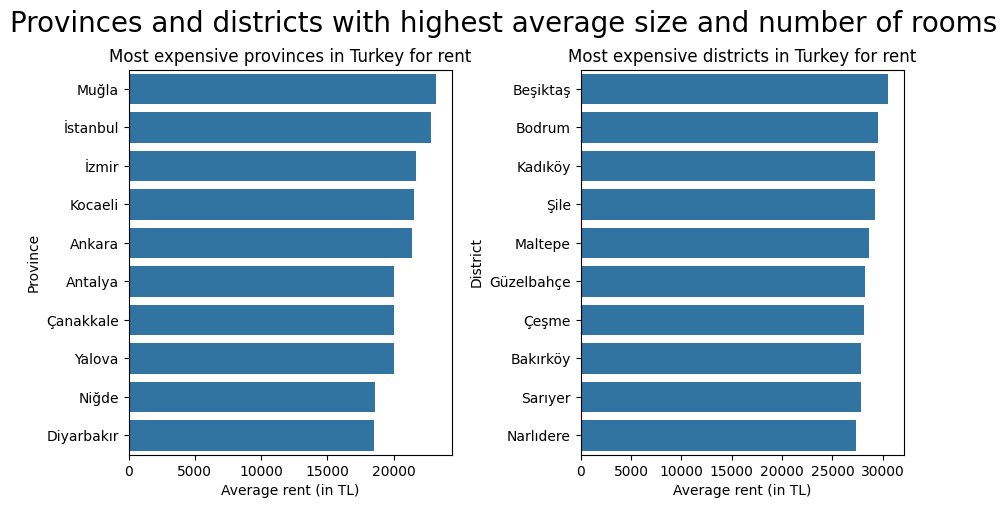

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

most_expensive_provinces = statistics_by_province[["province", "average_price", "number_ads"]].query("number_ads > 10").sort_values(by="average_price", ascending = False).head(10)
most_expensive_districts = statistics_by_district[["province", "district", "average_price", "number_ads"]].query("number_ads > 10").sort_values(by="average_price", ascending = False).head(10)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.subplots_adjust(hspace=0.2, wspace=0.4)
fig.suptitle("Provinces and districts with highest average size and number of rooms", fontsize= 20, y = 1)

sns.barplot(data = most_expensive_provinces, x = "average_price", y = "province", ax = axs[0])
axs[0].set_title("Most expensive provinces in Turkey for rent")
axs[0].set_ylabel("Province")
axs[0].set_xlabel("Average rent (in TL)")
sns.barplot(data = most_expensive_districts, x = "average_price", y = "district", ax = axs[1])
axs[1].set_title("Most expensive districts in Turkey for rent")
axs[1].set_ylabel("District")
axs[1].set_xlabel("Average rent (in TL)")
plt.show()

We see that, after filtering for provinces with more than 10 ads, the 5 provinces with the highest rents are Muğla, İstanbul, Kocaeli and Ankara. Muğla is a summer destination with rich towns like Bodrum, while İstanbul is the economic center of the country and Ankara is the capital, so it makes sense. 

If we move to districts, we see that, after filtering for those districts with more than 10 ads, the most expensive district is Beşiktaş in Istanbul, followed by Bodrum in Muğla, and Kadıköy, Şile and Maltepe in Istanbul. This is not a coincidence, as Beşiktaş and Kadıköy are the two richest neighborhoods in Istanbul, and Bodrum is a rich summertown. 

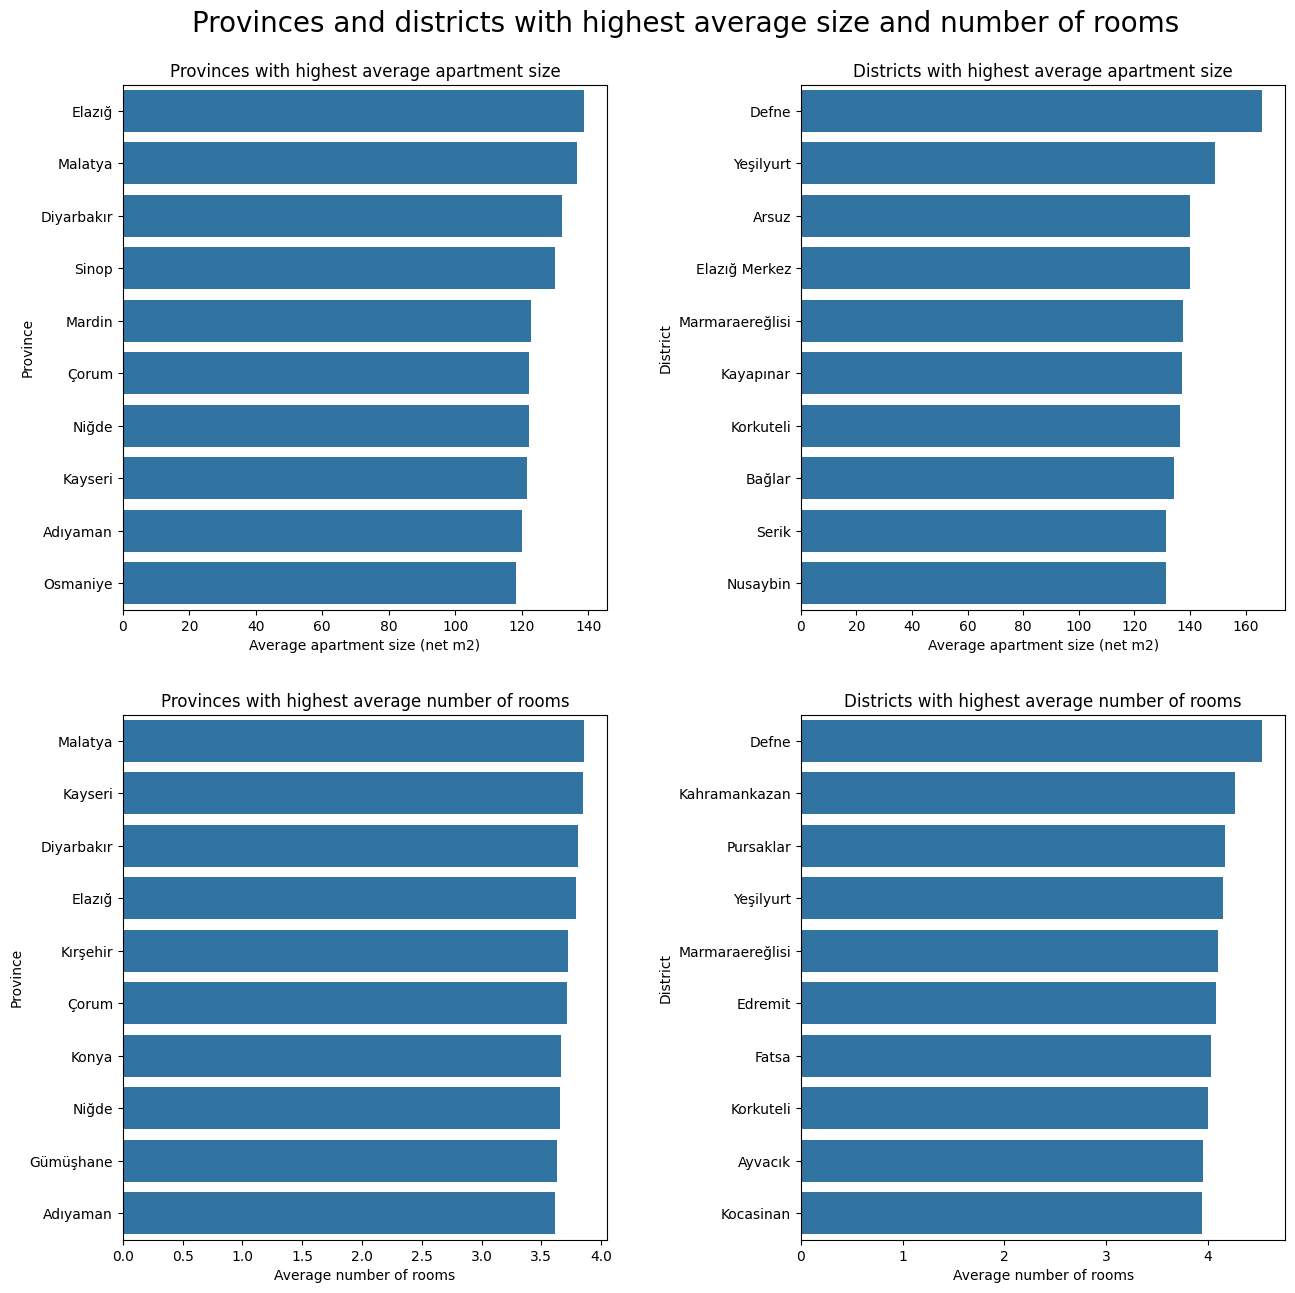

In [96]:
biggest_apartment_provinces = statistics_by_province[["province", "average_net_m2", "number_ads"]].query("number_ads > 10").sort_values(by="average_net_m2", ascending = False).head(10)
biggest_apartment_districts = statistics_by_district[["province", "district", "average_net_m2", "number_ads"]].query("number_ads > 10").sort_values(by="average_net_m2", ascending = False).head(10)
biggest_room_provinces = statistics_by_province[["province", "average_number_rooms", "number_ads"]].query("number_ads > 10").sort_values(by="average_number_rooms", ascending = False).head(10)
biggest_room_districts = statistics_by_district[["province", "district", "average_number_rooms", "number_ads"]].query("number_ads > 10").sort_values(by="average_number_rooms", ascending = False).head(10)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
plt.subplots_adjust(hspace=0.2, wspace=0.4)
fig.suptitle("Provinces and districts with highest average size and number of rooms", fontsize= 20, y = 0.93)
sns.barplot(ax=axs[0,0], data = biggest_apartment_provinces, x = "average_net_m2", y = "province")
axs[0,0].set_title("Provinces with highest average apartment size")
axs[0,0].set_xlabel("Average apartment size (net m2)")
axs[0,0].set_ylabel("Province")
sns.barplot(ax=axs[0,1], data = biggest_apartment_districts, x = "average_net_m2", y = "district")
axs[0,1].set_title("Districts with highest average apartment size")
axs[0,1].set_xlabel("Average apartment size (net m2)")
axs[0,1].set_ylabel("District")
sns.barplot(ax=axs[1,0], data = biggest_room_provinces, x = "average_number_rooms", y = "province")
axs[1,0].set_title("Provinces with highest average number of rooms")
axs[1,0].set_xlabel("Average number of rooms")
axs[1,0].set_ylabel("Province")
sns.barplot(ax=axs[1,1], data = biggest_room_districts, x = "average_number_rooms", y = "district")
axs[1,1].set_title("Districts with highest average number of rooms")
axs[1,1].set_xlabel("Average number of rooms")
axs[1,1].set_ylabel("District")
plt.show()

We see that, after filtering for those provinces and districts with less than 10 ads, that the provinces with the highest average apartment size (in m2) are Elazığ, Malatya, Diyarbakır, Sinop and Mardin. It's remarkable that 4 of these provinces are in Eastern Anatolia. If we consider districts instead, we see that the districts of Defne (Hatay), Yeşilyurt (Malatya), Arsuz (Hatay), Elazığ center and Marmaraereğlisi (Tekirdağ) are the ones with the highest average size in net m2.

Moving to the number of rooms, we see that the proivinces with the highest average number of rooms are Malatya, Kayseri, Diyarbakır, Elazığ and Kirşehir, while the districts with the highest average number of rooms are almost the same as those with the highest average size. 

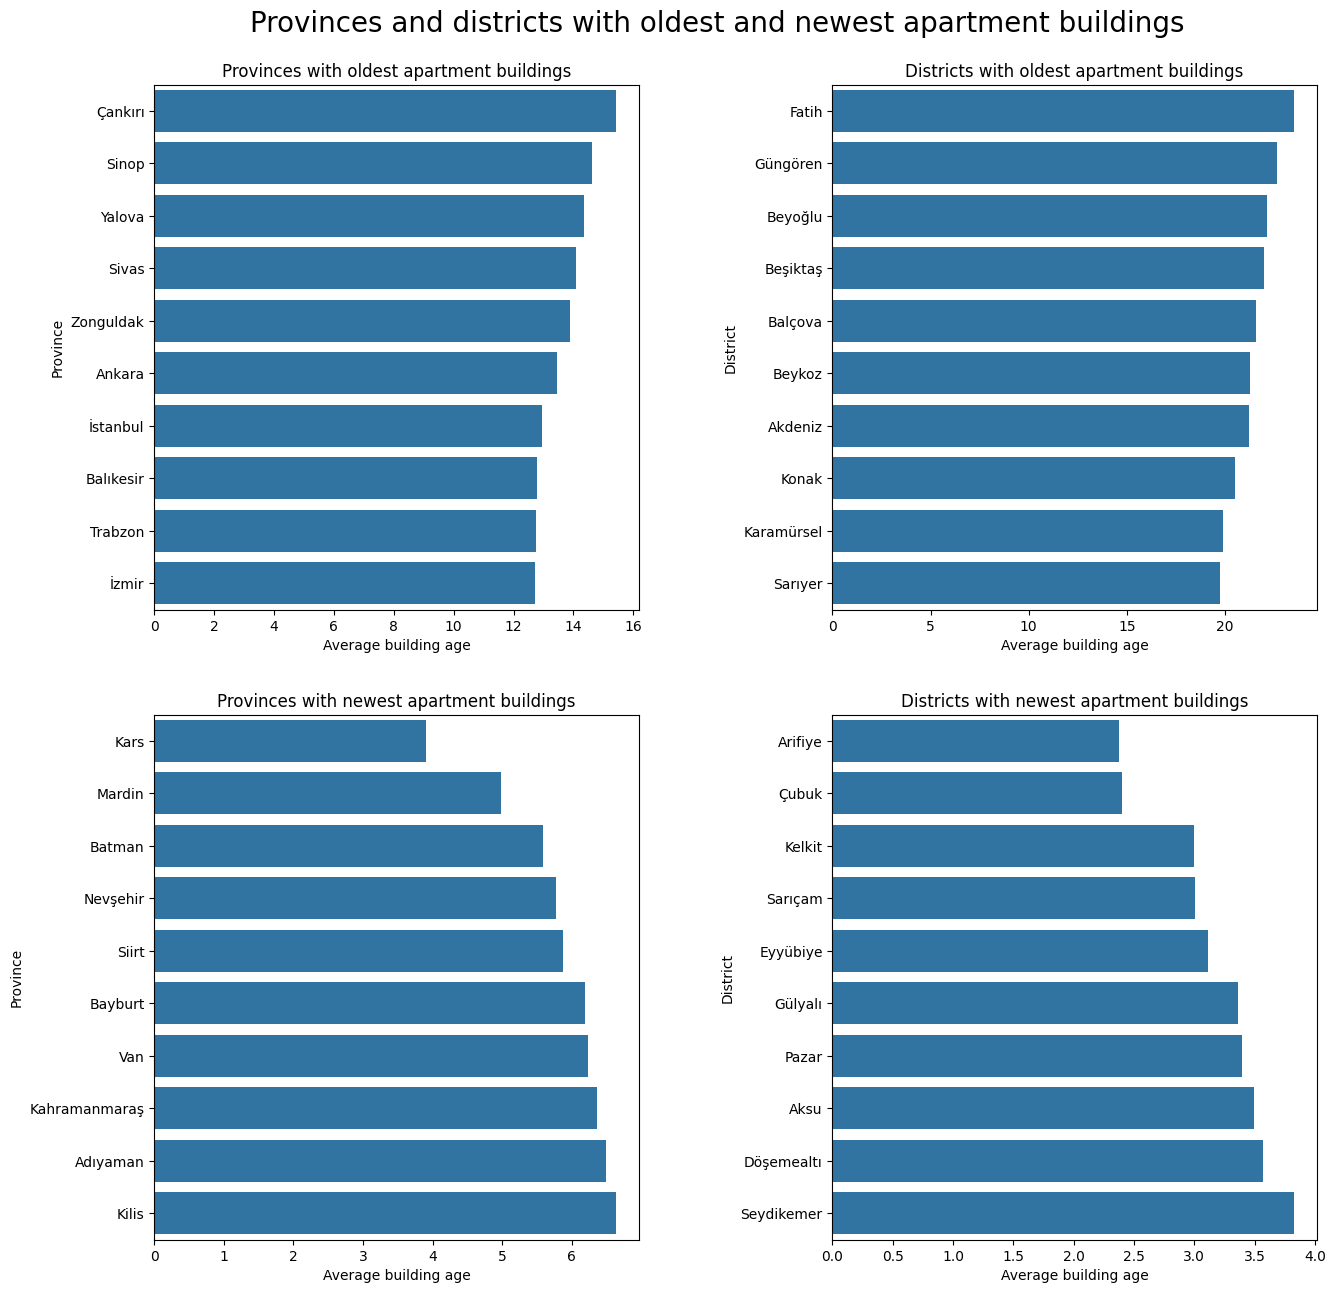

In [98]:
oldest_apartment_provinces = statistics_by_province[["province", "average_building_age", "number_ads"]].query("number_ads > 10").sort_values(by="average_building_age", ascending = False).head(10)
newest_apartment_provinces = statistics_by_province[["province", "average_building_age", "number_ads"]].query("number_ads > 10").sort_values(by="average_building_age", ascending = True).head(10)
oldest_apartment_districts = statistics_by_district[["province", "district", "average_building_age", "number_ads"]].query("number_ads > 10").sort_values(by="average_building_age", ascending = False).head(10)
newest_apartment_districts = statistics_by_district[["province", "district", "average_building_age", "number_ads"]].query("number_ads > 10").sort_values(by="average_building_age", ascending = True).head(10)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
plt.subplots_adjust(hspace=0.2, wspace=0.4)
fig.suptitle("Provinces and districts with oldest and newest apartment buildings", fontsize= 20, y = 0.93)
sns.barplot(ax=axs[0,0], data = oldest_apartment_provinces, x = "average_building_age", y = "province")
axs[0,0].set_title("Provinces with oldest apartment buildings")
axs[0,0].set_xlabel("Average building age")
axs[0,0].set_ylabel("Province")
sns.barplot(ax=axs[0,1], data = oldest_apartment_districts, x = "average_building_age", y = "district")
axs[0,1].set_title("Districts with oldest apartment buildings")
axs[0,1].set_xlabel("Average building age")
axs[0,1].set_ylabel("District")
sns.barplot(ax=axs[1,0], data = newest_apartment_provinces, x = "average_building_age", y = "province")
axs[1,0].set_title("Provinces with newest apartment buildings")
axs[1,0].set_xlabel("Average building age")
axs[1,0].set_ylabel("Province")
sns.barplot(ax=axs[1,1], data = newest_apartment_districts, x = "average_building_age", y = "district")
axs[1,1].set_title("Districts with newest apartment buildings")
axs[1,1].set_xlabel("Average building age")
axs[1,1].set_ylabel("District")
plt.show()

If we move to buildings age, after filtering for those provinces and districts with more than 10 ads, we see that the provinces with the oldest average building age are Çankırı, Sinop, Yalova, Sivas and Zonguldak. As for the districts, it's observed that the ones with the oldest buildings are mostly in the historical part of Istanbul (Güngören, Beyoğlu, Beşiktaş, Beykoz), with the historical center (Fatih) being the oldest one.

As for the provinces, we see that Kars, Mardin, Batman, Nevşehir and Siirt are the ones with the oldest average age. It's remarkable that 4 of these provinces are in Eastern Anatolia. As for the districts, Arifiye (Sakarya), Çubuk (Ankara), Kelkit (Gümüşhane), Sarıçam (Adana) and Eyyübiye (Şanlıurfa) are the ones with the newest buildings. 

## Representing this data in a map
We can represent this data in a map using **geopandas** library. To do so, first we need to download the .geojson files with the province (ADM1) and district (ADM2) boundaries of Turkey, which are available on the following link: https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-turkey 

Specifically, we want two files:
- geoBoundaries-TUR-ADM1.geojson (for the province boundaries)
- geoBoundaries-TUR-ADM2-geojson (for the district boundaries)

Once we have them downloaded, we can read them using geopandas, merge them with our province-level and district-level dataframes, and plot the maps using matplotlib and seaborn. Take into account that the district map looks incomplete as there were many districts with no apartments for rent.

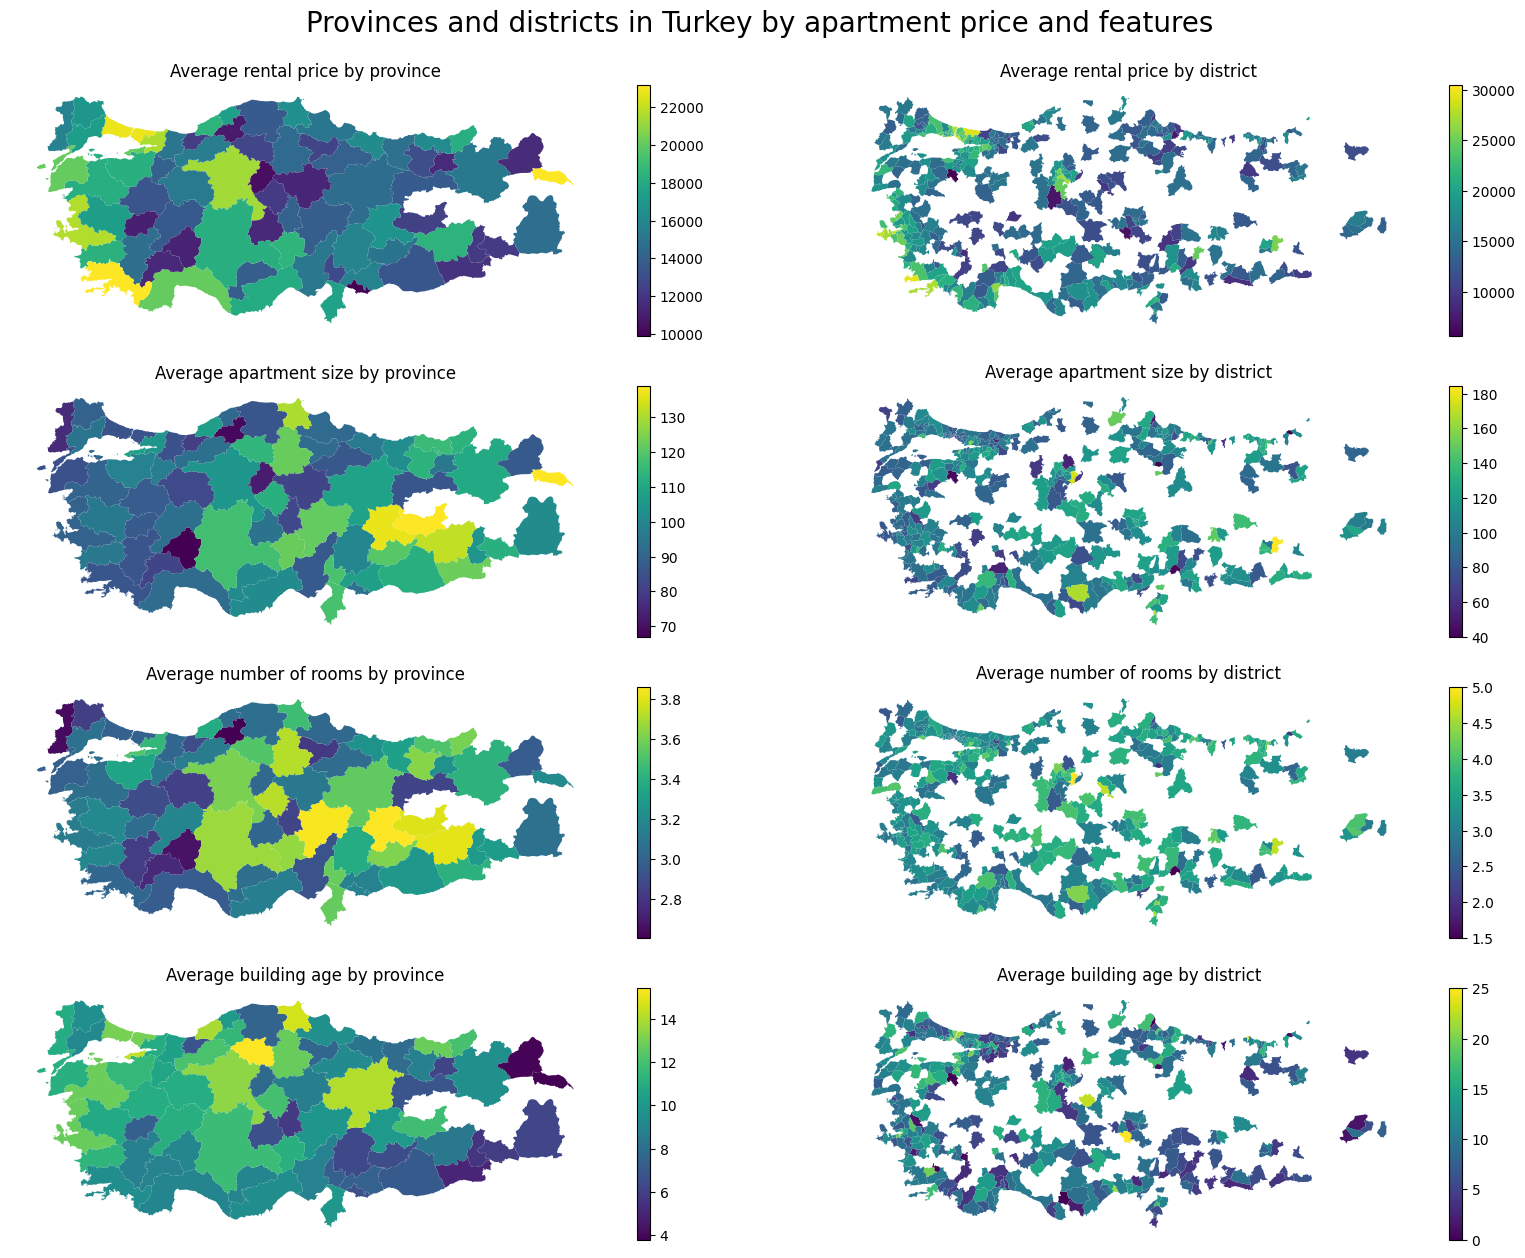

In [110]:
# Importing necessary libraries
import geopandas as gpd
from unidecode import unidecode

# Load the GeoJSON files with Turkish provinces and Turkish districts boundaries
provinces_map = gpd.read_file("geoBoundaries-TUR-ADM1.geojson")
districts_map = gpd.read_file("geoBoundaries-TUR-ADM2.geojson")

# As the name of provinces and districts slightly differ across datasets due to Turkish letters, we have to standardize them with unidecode
provinces_map["shapeName"] = provinces_map["shapeName"].apply(lambda x: unidecode(x).lower())
districts_map["shapeName"] = districts_map["shapeName"].apply(lambda x: unidecode(x).lower())
statistics_by_province["shapeName"] = statistics_by_province["province"].apply(lambda x: unidecode(x).lower())
statistics_by_district["shapeName"] = statistics_by_district["district"].apply(lambda x: unidecode(x).lower())

# Now we can merge the geographic dataframes with out provinces and districts datasets
provinces_map = provinces_map.merge(statistics_by_province, on = "shapeName")
districts_map = districts_map.merge(statistics_by_district, on = "shapeName")

## Now we can plot maps using matplotlib
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.suptitle("Provinces and districts in Turkey by apartment price and features", fontsize=20, y = 0.93)
axs[0,0] = provinces_map.query("number_ads > 1").plot(column="average_price", cmap="viridis", legend=True, ax=axs[0,0])
axs[0,0].set_title("Average rental price by province")
axs[0,0].set_axis_off()
axs[0,1] = districts_map.query("number_ads > 1").plot(column="average_price", cmap="viridis",legend=True, ax=axs[0,1])
axs[0,1].set_title("Average rental price by district")
axs[0,1].set_axis_off()
axs[1,0] = provinces_map.query("number_ads > 1").plot(column="average_net_m2", cmap="viridis", legend=True, ax=axs[1,0])
axs[1,0].set_title("Average apartment size by province")
axs[1,0].set_axis_off()
axs[1,1] = districts_map.query("number_ads > 1").plot(column="average_net_m2", cmap="viridis", legend=True, ax=axs[1,1])
axs[1,1].set_title("Average apartment size by district")
axs[1,1].set_axis_off()
axs[2,0] = provinces_map.query("number_ads > 1").plot(column="average_number_rooms", cmap="viridis", legend=True, ax=axs[2,0])
axs[2,0].set_title("Average number of rooms by province")
axs[2,0].set_axis_off()
axs[2,1] = districts_map.query("number_ads > 1").plot(column="average_number_rooms", cmap="viridis", legend=True, ax=axs[2,1])
axs[2,1].set_title("Average number of rooms by district")
axs[2,1].set_axis_off()
axs[3,0] = provinces_map.query("number_ads > 1").plot(column="average_building_age", cmap="viridis", legend=True, ax=axs[3,0])
axs[3,0].set_title("Average building age by province")
axs[3,0].set_axis_off()
axs[3,1] = districts_map.query("number_ads > 1").plot(column="average_building_age", cmap="viridis", legend=True, ax=axs[3,1])
axs[3,1].set_title("Average building age by district")
axs[3,1].set_axis_off()
plt.show()

## Analysis of numerical features
Besides aggregating apartment data by province and district, we can plot the distribution of our numeric features using histograms, as well as potential correlations between the features using matplotlib and seaborn.

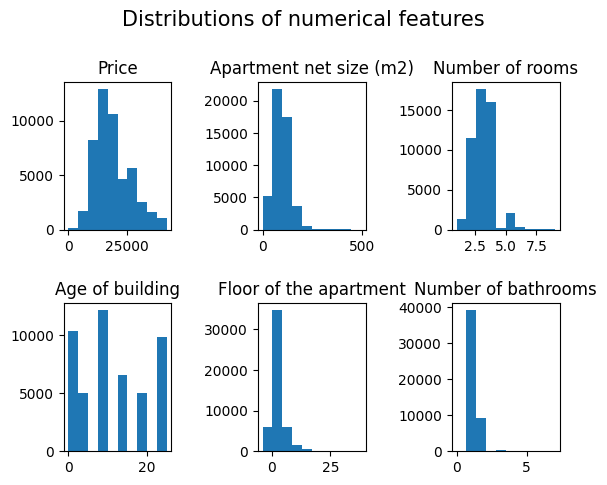

In [114]:
fig, ax = plt.subplots(2,3)
plt.subplots_adjust(hspace=0.2, wspace=0.8)
ax[0,0].hist(rented_apartments["price"])
ax[0,0].set_title("Price")
ax[0,1].hist(rented_apartments["net_m2"])
ax[0,1].set_title("Apartment net size (m2)")
ax[0,2].hist(rented_apartments["number_rooms"])
ax[0,2].set_title("Number of rooms")
ax[1,0].hist(rented_apartments["age_numeric"])
ax[1,0].set_title("Age of building")
ax[1,1].hist(rented_apartments["apartment_floor_numeric"])
ax[1,1].set_title("Floor of the apartment")
ax[1,2].hist(rented_apartments["number_bathrooms"])
ax[1,2].set_title("Number of bathrooms")
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Distributions of numerical features", fontsize = 15, y=1.03)
plt.show()

If we see the histograms, we see that, after removing the outliers, price seems to have a distribution that closely resembles the normal one (although is slightly skewed). Moreover, we see that other numeric features such as apartment size, number of rooms, floor of the apartment and number of bathrooms are right-skewed. Finally, age of building seems to have a more or less uniform distribution.

We can plot a heatmap to see the correlations between numerical features to see which features have higher influence on apartment rents:

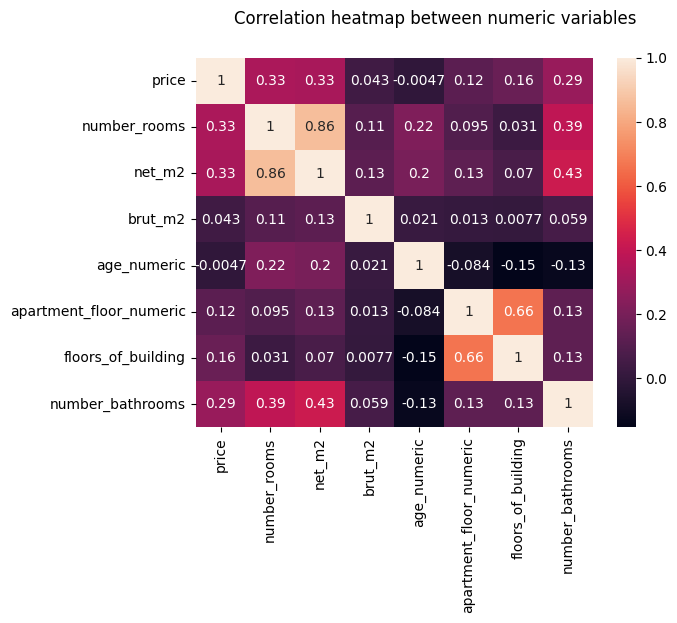

In [118]:
sns.heatmap(data=rented_apartments[["price", "number_rooms", "net_m2", "brut_m2", "age_numeric", "apartment_floor_numeric", "floors_of_building", "number_bathrooms"]].corr(), annot=True)
plt.suptitle("Correlation heatmap between numeric variables")
plt.show()

Here, we see that the number of rooms, the number of bathrooms and the net sqm have the highest correlation with apartment rental prices. Moreover, we see there is a very high correlation between the size of an apartment in sqm and the number of rooms it has, so I will remove the number of rooms in the analysis to avoid multicollinearity. 

As apartment size and rental price have the highest correlation, we can plot a regression plot to observe visually the specific relationship between these two variables:

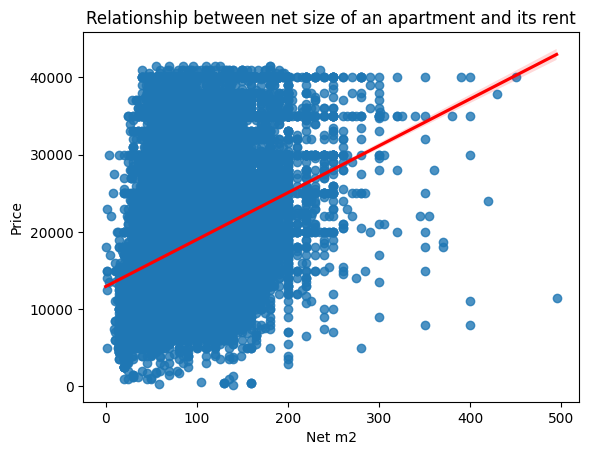

In [124]:
sns.regplot(x=rented_apartments["net_m2"], y = rented_apartments["price"], line_kws={"color":"red"}, ci=95)
plt.title("Relationship between net size of an apartment and its rent")
plt.xlabel("Net m2")
plt.ylabel("Price")
plt.show()

If we see the graph, it seems there is a clear positive relationship between the two variables, as it would be expected.

# Step 4: Feature engineering

After having conducted exploratory analysis, we need to one-hot encode our categorical features so they become numeric features that can be processed by machine learning models. As there are too many provinces, districts and neighborhoods, instead of transforming them in numeric features through one-hot encoding, I will use binary encoding. Moreover, I will get rid of number of rooms to avoid multicollinearity (as it's very highly correlated with net m2) and ad number (as it doesn't provide meaningful information for the prediction). 

In [110]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

target_encoder = TargetEncoder(smoothing=10)
rented_apartments["province_encoded"] = target_encoder.fit_transform(rented_apartments["province"], rented_apartments["price"])
rented_apartments["district_encoded"] = target_encoder.fit_transform(rented_apartments["district"], rented_apartments["price"])
rented_apartments["neighborhood_encoded"] = target_encoder.fit_transform(rented_apartments["neighborhood"], rented_apartments["price"])

# Dividing dataset into features and labels and dropping number of rooms and ad number
X = rented_apartments.drop(["price", "number_rooms", "ad_number", "province", "district", "neighborhood"], axis=1)
y = rented_apartments["price"].values

## Creating a list of categorical features
categorical_features = ["type_2", "heating_type", "usage_status", "title_deed_status", "price_status"]

## Setting up the One Hot Encoder, applying it to our categorical features and getting the names of the new features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_data = encoder.fit_transform(X[categorical_features])
categorical_feature_names = encoder.get_feature_names_out(categorical_features)

## Appending back these new numerical features to our dataset and dropping the categorical ones
encoded_df = pd.DataFrame(encoded_data, columns=categorical_feature_names)
X = pd.concat([X.drop(categorical_features, axis=1).reset_index(drop=True), encoded_df], axis=1)

Now, we should scale the values of features to the same range so no feature has a disproportionate impact on output. In this case, I will use the StandardScaler from sklearn.preprocessing:

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Step 5: Developing Machine Learning Models to predict prices

After the data is pre-processed, we can start training our Machine Learning models. In this case, I will use ML models available in **sklearn** library. First, we have to split the data into training and test sets. From now onwards, I will set up a seed = 42 to ensure reproducibility of results.

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)


As apartment rental price is a continuous variable, this is a regression problem. Therefore, we have to use regression models. Here, I will use the following models with default hyperparameters and cross-validation:

- Linear Regression
- Ridge
- Lasso
- Support Vector Regressor (SVR)
- Stochastic Gradient Descent Regressor (SGD)
- KNeighbors Regressor
- Decision Tree Regressor
- Gradient Boosting Regressor
- Random Forest Regressor
- AdaBoost (with Decision Tree Regressor as weak learner)
- CatBoost
- LightGBM

In order to compare model predictions, I will use the root mean-squared error (RMSE), and select the model with the lowest RMSE. After selecting the best model, I will proceed to hyperparameter tuning.

In [29]:
# Linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

linear = LinearRegression()
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear_rmse = np.mean(np.sqrt(cross_val_score(linear, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Linear Regression model RMSE:{linear_rmse}")

Linear Regression model RMSE:4795.3377936234865


In [30]:
# Ridge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

ridge = Ridge()
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_rmse = np.mean(np.sqrt(cross_val_score(ridge, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Ridge Regression model RMSE:{ridge_rmse}")

Ridge Regression model RMSE:4795.339808296417


In [31]:
# Lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

lasso = Lasso()
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_rmse = np.mean(np.sqrt(cross_val_score(lasso, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Lasso Regression model RMSE:{lasso_rmse}")

Lasso Regression model RMSE:4794.080886195743


In [32]:
# SVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

svr = SVR(kernel="linear")
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svr_rmse = np.mean(np.sqrt(cross_val_score(svr, X_train, y_train, scoring = scorer, cv=kf)))
print(f"SVR Regression model RMSE:{svr_rmse}")

SVR Regression model RMSE:4926.34539130683


In [34]:
# SGD Regressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

sgd = SGDRegressor()
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
sgd_rmse = np.mean(np.sqrt(cross_val_score(sgd, X_train, y_train, scoring = scorer, cv=kf)))
print(f"SGD Regression model RMSE:{sgd_rmse}")

SGD Regression model RMSE:96303253743.84059


In [35]:
# KNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

knn = KNeighborsRegressor()
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_rmse = np.mean(np.sqrt(cross_val_score(knn, X_train, y_train, scoring = scorer, cv=kf)))
print(f"KNN Regression model RMSE:{knn_rmse}")

KNN Regression model RMSE:5056.077419884683


In [36]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

tree = DecisionTreeRegressor(random_state=42)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree_rmse = np.mean(np.sqrt(cross_val_score(tree, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Decision Tree Regression RMSE:{tree_rmse}")

Decision Tree Regression RMSE:5925.632603825299


In [37]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

gradient_boosting = GradientBoostingRegressor(random_state=42)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gradient_boosting_rmse = np.mean(np.sqrt(cross_val_score(gradient_boosting, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Gradient Boosting Regression RMSE:{gradient_boosting_rmse}")

Gradient Boosting Regression RMSE:4530.201403835199


In [38]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

forest = RandomForestRegressor(random_state=42)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
forest_rmse = np.mean(np.sqrt(cross_val_score(forest, X_train, y_train, scoring = scorer, cv=kf)))
print(f"Random Forest Regression RMSE:{forest_rmse}")

Random Forest Regression RMSE:4193.726741289867


In [39]:
# AdaBoost Regressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

ada = AdaBoostRegressor(estimator=tree, random_state=42)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ada_rmse = np.mean(np.sqrt(cross_val_score(ada, X_train, y_train, scoring = scorer, cv=kf)))
print(f"AdaBoost Regression RMSE:{ada_rmse}")

AdaBoost Regression RMSE:4242.69035342052


In [18]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

lgbm = LGBMRegressor(verbose=0)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgbm_rmse = np.mean(np.sqrt(cross_val_score(lgbm, X_train, y_train, scoring = scorer, cv=kf)))
print(f"LGBM Regression RMSE:{lgbm_rmse}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBM Regression RMSE:4263.643854552339


In [73]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

cat = CatBoostRegressor(random_seed = 42, verbose=False)
scorer = make_scorer(mean_squared_error)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cat_rmse = np.mean(np.sqrt(cross_val_score(cat, X_train, y_train, scoring = scorer, cv=kf)))
print(f"CatBoost Regression RMSE:{cat_rmse}")

CatBoost Regression RMSE:4475.196228629042


After running all the models, we see that the one with the lowest RMSE is CatBoost Regression. Now, we will do hyperparameter tuning with cross-validation to find the best CatBoostRegressor model. To do so, I will use **optuna**, a library that uses advanced optimization algorithms to automate hyperparameter search.

In [41]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

def objective(trial):
    params = {
        
        'eval_metric': 'RMSE',
        'loss_function': 'RMSE',
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_int('random_strength', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'early_stopping_rounds': 100,
        'border_count': trial.suggest_int('border_count', 32, 255)   
    }
    model = CatBoostRegressor(**params, silent=True,thread_count=-1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scorer = make_scorer(mean_squared_error)
    mse_scores = cross_val_score(model, X_train, y_train, scoring = mse_scorer, cv=kf)
    
    return np.min(np.mean(np.sqrt(mse_scores)))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best hiperparameters: ', study.best_params)
print('Best rmse result: ', study.best_value)

[I 2025-03-19 14:12:43,813] A new study created in memory with name: no-name-c8b11c85-a166-4fe1-b857-7e4744550150
[I 2025-03-19 14:13:02,361] Trial 0 finished with value: 4036.2589304089606 and parameters: {'iterations': 772, 'depth': 7, 'learning_rate': 0.19235714851743366, 'l2_leaf_reg': 1.0071992303131505, 'bagging_temperature': 0.0751656710626184, 'random_strength': 3, 'min_data_in_leaf': 32, 'subsample': 0.8536560626667908, 'colsample_bylevel': 0.9264745336559498, 'grow_policy': 'SymmetricTree', 'border_count': 152}. Best is trial 0 with value: 4036.2589304089606.
[I 2025-03-19 14:13:10,059] Trial 1 finished with value: 4302.045609653983 and parameters: {'iterations': 298, 'depth': 4, 'learning_rate': 0.12492820594314198, 'l2_leaf_reg': 3.354303929871869, 'bagging_temperature': 0.7480702704205909, 'random_strength': 7, 'min_data_in_leaf': 11, 'subsample': 0.7365934256030937, 'colsample_bylevel': 0.7054090376947881, 'grow_policy': 'Lossguide', 'border_count': 249}. Best is trial 0 

Best hiperparameters:  {'iterations': 1968, 'depth': 10, 'learning_rate': 0.03202697126067996, 'l2_leaf_reg': 0.032847306294384815, 'bagging_temperature': 0.38876528966011903, 'random_strength': 10, 'min_data_in_leaf': 34, 'subsample': 0.7206637476642967, 'colsample_bylevel': 0.5389457369344757, 'grow_policy': 'Depthwise', 'border_count': 250}
Best rmse result:  3920.178034791867


In [113]:
# Once we have the model, we can use it to fit our data and save it so we can load it again when we want

cat_optimized = CatBoostRegressor(**study.best_params, silent=True)
cat_optimized.fit(X_train, y_train)
cat_optimized.save_model("cat_model")

Once we have the model, we can get the feature importances and plot them:

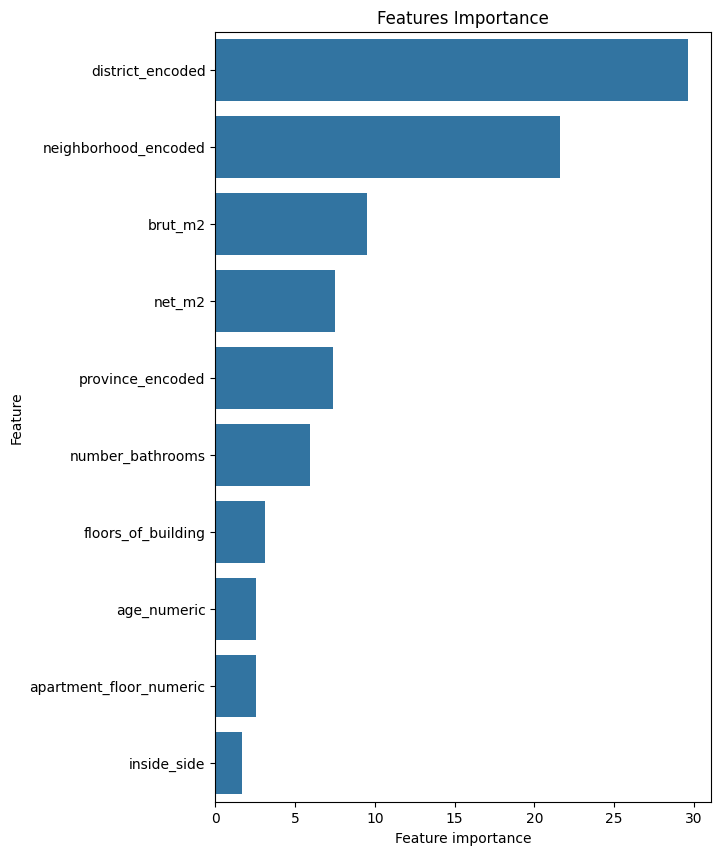

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = cat_optimized.feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by = "Importance", ascending=False).head(10)

plt.figure().set_figheight(10)
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Features Importance')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

As we see, the district and the neighborhood an apartment is located are the most important features in predicting rental prices, followed by brut and net squared meters of the apartment. 

## Conclusion

With this Machine Learning project, I have applied to a real business environment the following skills:

- Efficient webscraping of HTML websites in Python with html, BeautifulSoup, requests and urllib3
- Data import, cleaning and preprocessing with Pandas, Numpy and unidecode
- Data analysis and visualization with Pandas, matplotlib.pyplot, seaborn and geopandas
- Feature engineering, machine learning models and cross-validation with sklearn, lightgbm and catboost
- Hyperparameter tuning with optuna

Potential future steps to take this project further:

- Get sociodemographic data at the district-level, for instance, from official sources like TÜIK or specialized websites like endeksa.com.
- Implement advanced deep learning models with Keras, TensorFlow and Pytorch and check whether its predictions are more accurate.
- Use this model to predict the rents of apartments for sale in emlakjet.com and calculate the annual ROI of apartments.
- Deploy this model to production: automatize webscraping, data cleaning/preprocessing, and model fine-tuning with AWS and Flask.